# Cox-PH and DeepSurv

In this notebook we will train the [Cox-PH method](http://jmlr.org/papers/volume20/18-424/18-424.pdf), also known as [DeepSurv](https://bmcmedresmethodol.biomedcentral.com/articles/10.1186/s12874-018-0482-1).
We will use the METABRIC data sets as an example

A more detailed introduction to the `pycox` package can be found in [this notebook](https://nbviewer.jupyter.org/github/havakv/pycox/blob/master/examples/01_introduction.ipynb) about the `LogisticHazard` method.

The main benefit Cox-CC (and the other Cox methods) has over Logistic-Hazard is that it is a continuous-time method, meaning we do not need to discretize the time scale.

In [238]:
import numpy as np
import matplotlib.pyplot as plt


In [239]:
## Uncomment to install `sklearn-pandas`
# ! pip install sklearn-pandas

In [240]:
np.random.seed(1234)
_ = torch.manual_seed(123)

## Dataset

We load the METABRIC data set and split in train, test and validation.

In [351]:
from src.utilities import split_data
from src.preprocess import process_missing_values, main_preprocess, create_entity
from sklearn.model_selection import train_test_split

import pandas as pd

import warnings
import logging

# Régler le logger de Featuretools au niveau ERROR
logging.getLogger('featuretools.entityset').setLevel(logging.ERROR)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore",message=".*Ill-conditioned matrix.*")


GLOBAL = {
    "save_cox": False,
    "save_xgb": False,
    "save_lgbm": False,
    "save_rsf": False,
    "save_shap": False
}

PARAMS = {
    "size": 0.70,
    "clinical": ["CYTOGENETICS"],#["CYTOGENETICS"], # Possible: ["CYTOGENETICS", "HB/PLT", "logMONOCYTES", "logWBC", "logANC"] ["BM_BLAST+WBC", "BM_BLAST/HB", "HB*PLT", "HB/num_trisomies"]
    "molecular": ["GENE"],#["END-START"], # Possible: ["GENE", "EFFECT", "ALT", "REF", "END-START"]
    "merge": ["featuretools", "gpt"], # Possible: ["featuretools", "gpt"]
    "additional": [
        # ['cadd', 'phred'],
        # ['cadd', 'rawscore'],
        # # ['cadd', 'consequence'],
        # # ['cadd', 'bstatistic'],
        # # ['cadd', 'gerp', 'n'],
        # ['cadd', 'phast_cons', 'mammalian'],
        # ['cadd', 'phylop', 'mammalian'],
        # # ['snpeff', 'putative_impact'],
        # # ['snpeff', 'rank'],
        # # ['snpeff', 'total'],
        # # ['cadd', 'exon'],
        # # ['cadd', 'cds', 'rel_cds_pos']
        ],
    "xgb": {
        'max_depth': 2,
        'learning_rate': 0.05,
        'n_estimators': 300,
        'subsample': 0.5,
        'max_features': None,
        'random_state': 42
    },
    "lgbm": {
        'max_depth': 2,
        'learning_rate': 0.05,
        'verbose': 0
    },
    "rsf": {
    'n_estimators':260,  # Nombre d'arbres dans la forêt
    'max_depth':2,
    'min_samples_split':60,  # Nombre minimum d'échantillons requis pour splitter un nœud
    'min_samples_leaf':40,  # Nombre minimum d'échantillons par feuille
    'max_features':None,  # Sélection aléatoire des features
    'n_jobs':-1,  # Utilisation de tous les cœurs disponibles
    }
}


data = create_entity(PARAMS)
data = main_preprocess(data, PARAMS)
X, X_eval, y = split_data(data)

# Check if there are any columns that are not float or int in X
print(X.columns)
print(X.shape)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=(1 - PARAMS['size']), random_state=42)

X_train, X_test, X_eval = process_missing_values(X_train, X_test, X_eval, method="impute", strategy="median")

Index(['gene_ASXL1', 'gene_BCOR', 'gene_BCORL1', 'gene_BRCC3', 'gene_CBL',
       'gene_CEBPA', 'gene_CSF3R', 'gene_CTCF', 'gene_CUX1', 'gene_DDX41',
       ...
       'SKEW(molecular.START)', 'SKEW(molecular.VAF)', 'STD(molecular.DEPTH)',
       'STD(molecular.END)', 'STD(molecular.START)', 'STD(molecular.VAF)',
       'SUM(molecular.DEPTH)', 'SUM(molecular.END)', 'SUM(molecular.START)',
       'SUM(molecular.VAF)'],
      dtype='object', length=102)
(3173, 102)


In [352]:
def convert_survival_data(structured_array):
    """
    Convertit un tableau structuré de données de survie au format attendu.
    
    Args:
        structured_array: numpy.ndarray structuré avec ('event', '?') et ('time', '<f8')
    
    Returns:
        tuple: (times, events) où times est un array de float32 et events est un array de int32
    """
    import numpy as np
    
    # Extraction des temps et événements
    times = structured_array['time'].astype(np.float32)
    events = structured_array['event'].astype(np.int32)
    
    return (times, events)

def convert_float32(X_train, X_test, X_eval):
    """
    Convertit les données
    """

    X_train = X_train.astype('float32')
    X_test = X_test.astype('float32')
    X_eval = X_eval.astype('float32')

    return (X_train, X_test, X_eval)

from sksurv.metrics import concordance_index_ipcw

def score_method(model, X_train_deep, X_test_deep, y_train, y_test, reverse=False):
    X_train_deep = X_train_deep.astype(np.float32)
    X_test_deep = X_test_deep.astype(np.float32)
    cindex_train = concordance_index_ipcw(y_train, y_train, model.predict(X_train_deep).flatten() if not reverse else -model.predict(X_train_deep), tau=7)[0]
    cindex_test = concordance_index_ipcw(y_train, y_test, model.predict(X_test_deep).flatten() if not reverse else -model.predict(X_test_deep), tau=7)[0]
    print(f"{model.__class__.__name__} Model Concordance Index IPCW on train: {cindex_train:.3f}")
    print(f"{model.__class__.__name__} Model Concordance Index IPCW on test: {cindex_test:.3f}")
    return f"score_{cindex_train:.3f}_{cindex_test:.3f}"

X_train_deep, X_test_deep, X_eval_deep = convert_float32(X_train, X_test, X_eval)

y_train_deep = convert_survival_data(y_train)
y_test_deep = convert_survival_data(y_test)

In [368]:
params = {
    'num_nodes': [128, 128, 23],  # Augmentation de la capacité du modèle
    'out_features': 1,
    'batch_norm': True,
    'dropout': 0.0,              # Vous pouvez tester avec ou sans dropout
    'output_bias': False,
    'in_features': X_train_deep.shape[1]
}
params_CoxHP = {
    "batch_size": 256,
    "lr": 0.0005,              # Taux d'apprentissage légèrement réduit
    "epochs": 512,             # Augmentation du nombre d'époques
    "verbose": False
}

LogLikehood:  -6.0899796
CoxPH Model Concordance Index IPCW on train: 0.698
CoxPH Model Concordance Index IPCW on test: 0.592


'score_0.698_0.592'

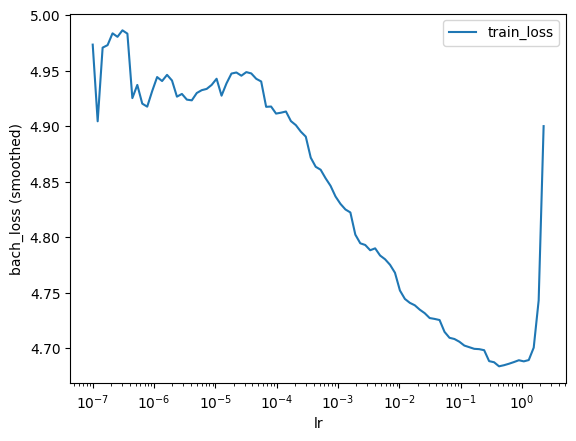

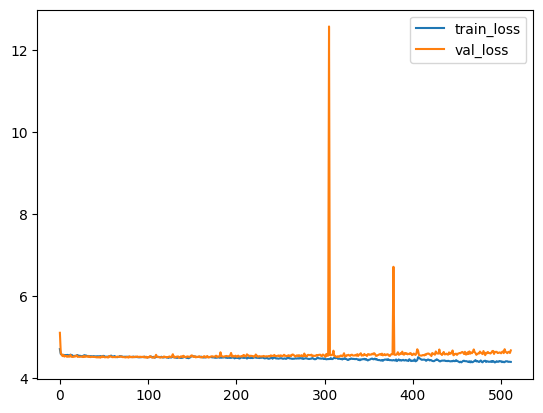

In [371]:
from sklearn.preprocessing import StandardScaler

import torch
import torchtuples as tt

from pycox.models import CoxPH

np.random.seed(42)
_ = torch.manual_seed(4)

params['in_features'] = X_train_deep.shape[1]

net = tt.practical.MLPVanilla(**params)
model = CoxPH(net, tt.optim.Adam)

model.optimizer.set_lr(params_CoxHP['lr'])

batch_size = params_CoxHP['batch_size']

lrfinder = model.lr_finder(X_train_deep, y_train_deep, batch_size, tolerance=10)
_ = lrfinder.plot()

epochs = params_CoxHP['epochs']
callbacks = []#[tt.callbacks.EarlyStopping()]
verbose = params_CoxHP['verbose']

log = model.fit(X_train_deep, y_train_deep, batch_size, epochs, callbacks, verbose,
                val_data=(X_test_deep, y_test_deep), val_batch_size=batch_size)

_ = log.plot()

print("LogLikehood: ", model.partial_log_likelihood(*(X_test_deep, y_test_deep)).mean())

score_method(model, X_train_deep, X_test_deep, y_train, y_test, reverse=False)

In [230]:
score_method(model, X_train_deep, X_test_deep, y_train, y_test, reverse=False)

CoxPH Model Concordance Index IPCW on train: 0.677
CoxPH Model Concordance Index IPCW on test: 0.673


'score_0.677_0.673'

In [348]:

from datetime import datetime

def predict_and_save(X_eval, model, method="featuretools"):
    df_eval = pd.read_csv("data/X_test/clinical_test.csv")
    prediction_on_test_set = -model.predict(X_eval) if model.__class__.__name__ == "Booster" else model.predict(X_eval).flatten()
    submission = pd.Series(prediction_on_test_set, index=df_eval['ID'], name='risk_score')
    submission.to_csv(f'output/{model.__class__.__name__}_submission_{method}_{datetime.now().strftime("%Y%m%d%H%M%S")}.csv')

predict_and_save(X_eval_deep, model, method="deepCoxHP")

In [258]:
model.predict(X_eval_deep)

array([[0.66539764],
       [0.73227894],
       [0.6260255 ],
       ...,
       [0.98859835],
       [0.6928998 ],
       [1.1273339 ]], dtype=float32)

## GPTT


In [237]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchtuples as tt
from pycox.models import CoxPH

class DeepSurvCustom(nn.Module):
    def __init__(self,
                 numeric_dim,         # nombre de features numériques (ex. VAF, DEPTH, etc.)
                 gene_vocab_size,     # taille du vocabulaire pour GENE
                 gene_emb_dim,        # dimension de l'embedding pour GENE
                 effect_vocab_size,   # taille du vocabulaire pour EFFECT
                 effect_emb_dim,      # dimension de l'embedding pour EFFECT
                 prot_vocab_size,     # taille du vocabulaire pour PROTEIN_CHANGE
                 prot_emb_dim,        # dimension de l'embedding pour PROTEIN_CHANGE
                 hidden_dim):         # dimension de la couche cachée
        super(DeepSurvCustom, self).__init__()
        # Couches d'embedding pour les variables catégorielles
        self.gene_embedding = nn.Embedding(gene_vocab_size, gene_emb_dim)
        self.effect_embedding = nn.Embedding(effect_vocab_size, effect_emb_dim)
        self.prot_embedding = nn.Embedding(prot_vocab_size, prot_emb_dim)
        
        # La dimension totale en entrée est la somme des features numériques et des dimensions d'embedding
        total_feature_dim = numeric_dim + gene_emb_dim + effect_emb_dim + prot_emb_dim
        
        # Réseau entièrement connecté
        self.fc1 = nn.Linear(total_feature_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1)  # Sortie de dimension 1 pour le score de risque
        
    def forward(self, x):
        """
        On suppose que x est un tensor de taille (batch_size, total_input_dim)
        et que l'on a pré-concaténé :
          - Les features numériques (numeric_dim colonnes),
          - Les indices pour GENE (1 colonne),
          - Les indices pour EFFECT (1 colonne),
          - Les indices pour PROTEIN_CHANGE (1 colonne).
        """
        # Définition des dimensions
        numeric_dim = 4  # par exemple, si vous avez 4 features numériques (adapté à vos données)
        # Les trois dernières colonnes sont respectivement gene_id, effect_id et prot_id
        numeric_features = x[:, :numeric_dim].float()  # (batch_size, numeric_dim)
        gene_ids = x[:, numeric_dim].long()             # (batch_size,)
        effect_ids = x[:, numeric_dim+1].long()           # (batch_size,)
        prot_ids = x[:, numeric_dim+2].long()             # (batch_size,)
        
        # Passage par les embeddings
        gene_emb = self.gene_embedding(gene_ids)          # (batch_size, gene_emb_dim)
        effect_emb = self.effect_embedding(effect_ids)      # (batch_size, effect_emb_dim)
        prot_emb = self.prot_embedding(prot_ids)            # (batch_size, prot_emb_dim)
        
        # Concaténation de toutes les features
        x_cat = torch.cat([numeric_features, gene_emb, effect_emb, prot_emb], dim=1)
        
        # Passage par le réseau fully-connected
        x_cat = F.relu(self.fc1(x_cat))
        risk_score = self.fc2(x_cat)
        return risk_score

# Exemple d'initialisation des dimensions (à adapter à vos données)
numeric_dim = 4   # Par exemple, VAF, DEPTH, mutation burden, etc.
gene_vocab_size = 5000     # Nombre de gènes différents (à définir)
gene_emb_dim = 16
effect_vocab_size = 10       # Nombre de catégories pour EFFECT (ex: stop_gained, non_synonymous, frameshift, etc.)
effect_emb_dim = 8
prot_vocab_size = 1000      # Nombre de catégories pour PROTEIN_CHANGE (si vous les catégorisez)
prot_emb_dim = 16
hidden_dim = 64

# Instanciation du modèle
net = DeepSurvCustom(numeric_dim, gene_vocab_size, gene_emb_dim,
                     effect_vocab_size, effect_emb_dim,
                     prot_vocab_size, prot_emb_dim,
                     hidden_dim)

# Pour intégrer ce réseau dans un modèle CoxPH (DeepSurv) avec PyCox:
model = CoxPH(net, tt.optim.Adam)
model.optimizer.set_lr(0.001)

# Ensuite, préparez vos données d'entraînement
# X_train_deep devra être un tensor de taille (n_samples, numeric_dim+3)
# (les 3 colonnes pour gene, effect, et protein_change, sous forme d'indices)
# y_train_deep doit être formaté comme requis par PyCox (typiquement un objet survial dataset)

# Exemple fictif pour créer des données d'entrée :
import numpy as np
batch_size = 32
num_samples = 100
# Générons des features numériques aléatoires
numeric_data = np.random.randn(num_samples, numeric_dim)
# Générons des indices aléatoires pour les variables catégorielles
gene_data = np.random.randint(0, gene_vocab_size, (num_samples, 1))
effect_data = np.random.randint(0, effect_vocab_size, (num_samples, 1))
prot_data = np.random.randint(0, prot_vocab_size, (num_samples, 1))

# Concaténation pour obtenir X_train_deep de taille (num_samples, numeric_dim+3)
X_train_deep = np.hstack([numeric_data, gene_data, effect_data, prot_data])
X_train_deep = torch.tensor(X_train_deep, dtype=torch.float)

# y_train_deep doit être préparé selon le format requis par pycox (par exemple, avec un array de durées et un array d'événements)
# Ici, c'est juste un exemple fictif
y_train_deep = (torch.rand(num_samples)*100, torch.randint(0,2,(num_samples,)))  # (durée, événement)

# Puis vous pouvez entraîner le modèle comme vous le faisiez :
log = model.fit(X_train_deep, y_train_deep, batch_size, epochs=100, verbose=True)
print("Partial Log Likelihood:", model.partial_log_likelihood(*(X_train_deep, y_train_deep)).mean())

0:	[0s / 0s],		train_loss: 2.0636
1:	[0s / 0s],		train_loss: 2.0853
2:	[0s / 0s],		train_loss: 1.8606
3:	[0s / 0s],		train_loss: 2.0353
4:	[0s / 0s],		train_loss: 1.9938
5:	[0s / 0s],		train_loss: 1.8664
6:	[0s / 0s],		train_loss: 1.9835
7:	[0s / 0s],		train_loss: 1.9122
8:	[0s / 0s],		train_loss: 1.9015
9:	[0s / 0s],		train_loss: 1.9458
10:	[0s / 0s],		train_loss: 1.8621
11:	[0s / 0s],		train_loss: 1.7802
12:	[0s / 0s],		train_loss: 1.8680
13:	[0s / 0s],		train_loss: 1.7324
14:	[0s / 0s],		train_loss: 1.7895
15:	[0s / 0s],		train_loss: 1.6907
16:	[0s / 0s],		train_loss: 1.7296
17:	[0s / 0s],		train_loss: 1.6474
18:	[0s / 0s],		train_loss: 1.6476
19:	[0s / 0s],		train_loss: 1.5437
20:	[0s / 0s],		train_loss: 1.5414
21:	[0s / 0s],		train_loss: 1.5855
22:	[0s / 0s],		train_loss: 1.4552
23:	[0s / 0s],		train_loss: 1.4427
24:	[0s / 0s],		train_loss: 1.4470
25:	[0s / 0s],		train_loss: 1.4744
26:	[0s / 0s],		train_loss: 1.4637
27:	[0s / 0s],		train_loss: 1.4192
28:	[0s / 0s],		train_loss: 1.